## Table of Content

## Introduction

In this notebook, we explore content-based product recommendations using customer purchase data and product descriptions. We implement two key approaches for representing product text: a traditional TF-IDF vectorizer and a modern BERT-based sentence embedding model. Using these representations, we apply nearest neighbor search to identify similar items, then evaluate and visualize recommendations for individual customers. This work demonstrates how natural language processing techniques can enhance recommendation systems by capturing the semantic meaning of product descriptions.

### Importing Libraries and Data

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import re
import string

from PIL import Image

from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer


In [2]:
#Loading Data
articles_df = pd.read_pickle('../data/processed/cleaned_articles.pkl')
transactions_df = pd.read_pickle('../data/processed/cleaned_transactions.pkl')
customers_df = pd.read_pickle('../data/processed/cleaned_customers.pkl')

## Preprocessing Data

In [3]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105107 entries, 0 to 105106
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   article_id                    105107 non-null  int64  
 1   product_code                  105107 non-null  int64  
 2   prod_name                     105107 non-null  object 
 3   product_type_no               105107 non-null  int64  
 4   product_type_name             105107 non-null  object 
 5   product_group_name            105107 non-null  object 
 6   graphical_appearance_no       105107 non-null  int64  
 7   graphical_appearance_name     105107 non-null  object 
 8   colour_group_code             105107 non-null  int64  
 9   colour_group_name             105107 non-null  object 
 10  perceived_colour_value_id     105107 non-null  int64  
 11  perceived_colour_value_name   105107 non-null  object 
 12  perceived_colour_master_id    105107 non-nul

For our Content Base Recommnedation system, we will not be using the majority of the columns in the articles_df. So, we can proceed by dropping the columns that are unnecessary for our recommendation systems and export the csv for later use.



In [4]:
articles_df = articles_df[[
    'article_id',
    'product_type_name',
    'index_group_name',
    'section_name',
    'product_group_name',
    'garment_group_name',
    'colour_group_name',
    'preprocessed_desc'
    ]]


In [5]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105107 entries, 0 to 105106
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   article_id          105107 non-null  int64 
 1   product_type_name   105107 non-null  object
 2   index_group_name    105107 non-null  object
 3   section_name        105107 non-null  object
 4   product_group_name  105107 non-null  object
 5   garment_group_name  105107 non-null  object
 6   colour_group_name   105107 non-null  object
 7   preprocessed_desc   105107 non-null  object
dtypes: int64(1), object(7)
memory usage: 7.2+ MB


When suggesting similar products, Color is an important factor. To improve the quality of our text features, we’re adding the colour_group_name to the detail_desc column. This helps capture more complete information, as the original descriptions don’t include color.

In [6]:
# Add colour_group_name to detail_desc
articles_df.loc[:, 'preprocessed_desc'] = articles_df.apply(
    lambda row: f"{row['preprocessed_desc']} Color: {row['colour_group_name']}", axis=1
)

In [7]:
articles_df[['article_id', 'preprocessed_desc']].head(2)

,article_id,preprocessed_desc
0,108775015,jersey top narrow shoulder strap Color: Black
1,108775044,jersey top narrow shoulder strap Color: White


The show_article function shows the image and details of a product based on its article_id. It looks up the product in the data, builds the correct file path for the image, and displays it with its product type and description (if available). This helps visually understand what the product looks like and what it is.



In [8]:

def show_article(article_id, articles_df, image_dir ):
    # Get article row
    article = articles_df[articles_df['article_id'] == article_id].iloc[0]
    
    # Extract and format image path
    article_id_str = str(article_id).zfill(10)  # Ensure it has 10 digits
    folder = article_id_str[:3]
    filename = f"{article_id_str}.jpg"
    image_path = os.path.join(image_dir, folder, filename)

    # Plot
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)
        plt.figure(figsize=(4, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Article ID: {article_id}\n{article['product_type_name']}", fontsize=10)
        plt.show()

        print("📌 Description:")
        print(article['preprocessed_desc'] if 'preprocessed_desc' in article else "No description found.")
    else:
        print(f"Image not found at path: {image_path}")


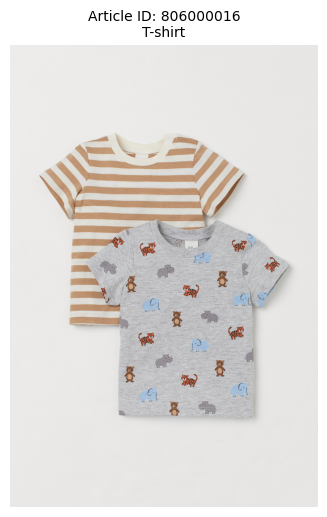

📌 Description:
shirt soft cotton jersey press stud one shoulder except size ½ Color: Grey


In [9]:
# Set your local path to the images folder (e.g., "../images/")
image_dir = "../data/images"

# Show article by ID
sample_id = articles_df['article_id'].sample(1).iloc[0]
show_article(sample_id, articles_df, image_dir)


## Modelling



## TF-IDF:

#### Vectorize preprocessed_desc

Here I turn the cleaned description column into numerical vectors, using ***TF-IDF***

We use TfidfVectorizer to convert the preprocessed product descriptions into numerical features. This captures the importance of words (and word pairs) across all products. The result is a matrix (desc_tfidf) that can be used for similarity comparisons and recommendation models.

In [10]:

#Define a Tfid Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

#Fit and Transform our description with Tfid Vectorizer
desc_tfidf = tfidf_vectorizer.fit_transform(articles_df['preprocessed_desc'])



### KNN to Find Similar Articles

We use the K-Nearest Neighbors (KNN) algorithm with cosine similarity to find products with similar descriptions. After fitting the model on the TF-IDF vectors, we retrieve the top 5 most similar items for each product. This forms the basis for content-based recommendations.

In [11]:
# Initialize model — use cosine distance
TFIDF_knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
TFIDF_knn.fit(desc_tfidf)

# Top-5 similar items for each article
distances, indices = TFIDF_knn.kneighbors(desc_tfidf)

In [12]:
article_ids = articles_df['article_id'].values

# Map indices to article IDs
TFIDF_similar_articles = {
    article_ids[i]: article_ids[indices[i][1:]]  
    for i in range(len(article_ids))
}


We create a dictionary (similar_articles) that maps each article to a list of its top 5 most similar articles (excluding itself). This uses the indices from the KNN model to reference the original article_ids.

Then wshow_similar_articles function displays the image of a selected product alongside its top similar items. This helps visually compare the query article with its recommended alternatives, based on description similarity.

In [13]:

def get_image_path(article_id, image_base_path):
    article_id_str = str(article_id).zfill(10)
    folder = article_id_str[:3]
    filename = f"{article_id_str}.jpg"
    return os.path.join(image_base_path, folder, filename)


In [14]:
def show_similar_articles(selected_article_id,TFIDF_similar_articles,  image_base_path='../data/images'):
    similar_ids =TFIDF_similar_articles[selected_article_id]
    all_ids = [selected_article_id] + list(similar_ids)
    
    plt.figure(figsize=(15, 4))
    
    for i, article_id in enumerate(all_ids):
        img_path = get_image_path(article_id, image_base_path)
        try:
            img = Image.open(img_path)
            plt.subplot(1, len(all_ids), i + 1)
            plt.imshow(img)
            plt.axis('off')
            title = "Query" if i == 0 else f"Similar {i}"
            plt.title(title, fontsize=10)
        except FileNotFoundError:
            print(f"Image not found for article {article_id}")
    
    plt.tight_layout()
    plt.show()


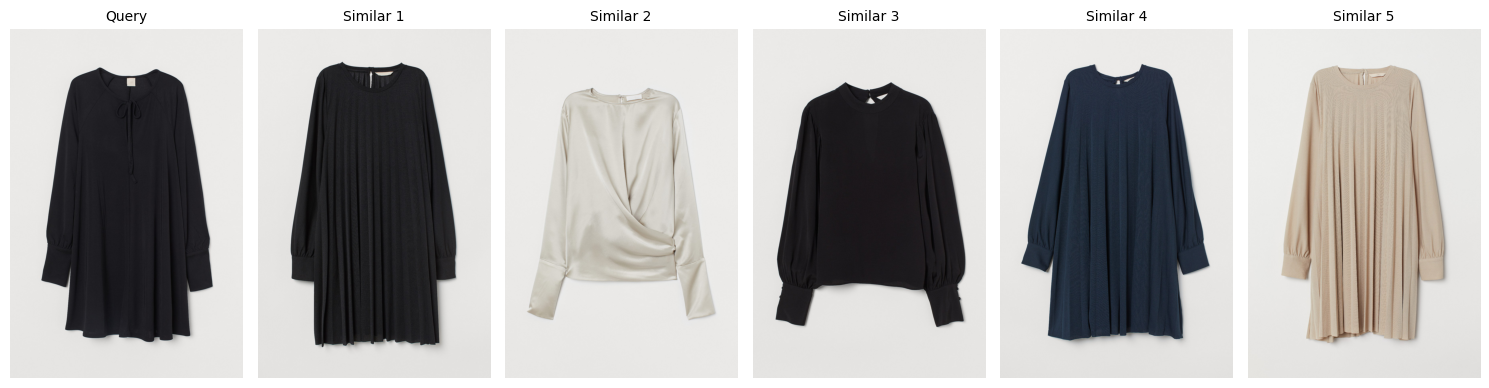

In [15]:
# Choose a sample article ID from your dataset

sample_article_id = 956217002

# Show similar articles based on your earlier similarity dict
show_similar_articles(sample_article_id,TFIDF_similar_articles, image_base_path='../data/images')


We can print cleaned descriptions for selected article and similar atricles to show why they were matched:

In [17]:
print("Query article description:")
print(articles_df[articles_df['article_id'] == sample_article_id]['preprocessed_desc'].values[0])

print("\nSimilar articles descriptions:")
for sim_id in TFIDF_similar_articles[sample_article_id]:
    desc = articles_df[articles_df['article_id'] == sim_id]['preprocessed_desc'].values[0]
    print(f"- {sim_id}: {desc}")


Query article description:
short line dress jersey round neckline v shape open front narrow tie long voluminous raglan sleeves wide cuff cover button Color: Black

Similar articles descriptions:
- 733248002: short line dress pleat jersey round neckline small open button back neck long sleeves wide button cuff Color: Black
- 791621001: wide top soft gently drape silk round neckline cover button back neck long sleeves wide cuff cover button tie hem wrap around tie waist Color: Light Beige
- 903934004: blouse viscose crêpe weave small stand collar open back cover button back neck long voluminous sleeves wide cuff cover button Color: Black
- 733248004: short line dress pleat jersey round neckline small open button back neck long sleeves wide button cuff Color: Dark Blue
- 733248001: short line dress pleat jersey round neckline small open button back neck long sleeves wide button cuff Color: Beige


## Bert

#### Loading a BERT-Based Sentence Embedding Model
We use the all-MiniLM-L6-v2 model from SentenceTransformers to convert product descriptions into dense vector embeddings. This model captures semantic meaning more effectively than traditional methods like TF-IDF.

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


We convert the preprocessed product descriptions into vector embeddings using the BERT model. These embeddings capture the semantic meaning of each description and will be used to find similar products based on content.

In [19]:

article_texts = articles_df['preprocessed_desc'].tolist()

# Generate embeddings
bert_embeddings = model.encode(article_texts, show_progress_bar=True)


Batches:   0%|          | 0/3285 [00:00<?, ?it/s]

### KNN for BERT

We apply K-Nearest Neighbors on the BERT-generated embeddings using cosine similarity to identify similar product descriptions. For each product, we store its top 5 most similar items (excluding itself) in a dictionary called bert_similar_articles_knn.

In [20]:
bert_knn = NearestNeighbors(n_neighbors=6,  
                       metric='cosine', 
                       algorithm='brute') 
bert_knn.fit(bert_embeddings)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [21]:
# Get top 5 similar articles
distances, indices = bert_knn.kneighbors(bert_embeddings)


In [22]:
bert_similar_articles_knn = {}

for i, article_id in enumerate(articles_df['article_id']):
    neighbors = indices[i][1:]  
    neighbor_ids = articles_df.iloc[neighbors]['article_id'].tolist()
    bert_similar_articles_knn[article_id] = neighbor_ids


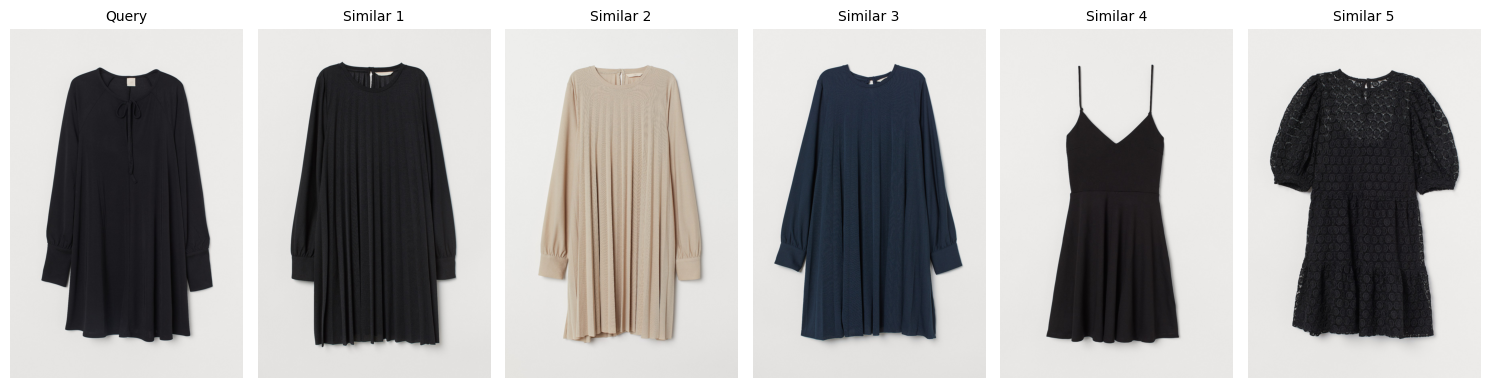

In [23]:

sample_article_id = 956217002

# Show similar articles based on the earlier similarity dict
show_similar_articles(sample_article_id, bert_similar_articles_knn, image_base_path='../data/images')


### Observing Recommendation Quality

Instead of focusing on numerical scores, we visually compared the recommendations from both the TF-IDF and BERT-based models. In several examples, including the one with a short black dress, both models returned similar styles. However, the BERT model performed better in capturing subtle semantic similarities — for instance, recommending dresses with matching patterns and cuts, even when the color differed.

This shows that BERT is more effective at understanding the style and context of product descriptions, making it a strong choice for content-based recommendations.

### Personolized Recommendation

We create two dictionaries:

    article_id_to_index: Maps each article_id to its corresponding row index in the dataset.

    index_to_article_id: Reverses this mapping, linking indices back to their original article_ids.

These mappings are useful for quickly switching between article identifiers and their positions in model outputs like similarity indices.

In [24]:
article_id_to_index = {aid: idx for idx, aid in enumerate(articles_df['article_id'])}
index_to_article_id = {v: k for k, v in article_id_to_index.items()}


#### Collecting Customer Purchase History

In [25]:
customer_purchases = transactions_df.groupby('customer_id')['article_id'].apply(list)


We define a function recommend_for_customer() that generates personalized recommendations for a given customer:

It retrieves all articles previously purchased by the customer.

For each item, it uses BERT-based embeddings and KNN search to find similar articles.

Already purchased items are excluded to avoid repetition.

It returns the top k unique recommendations along with a sample of the customer's past purchases.

The show_article_images() function then visualizes these items using their images, making it easier to compare what the customer bought with what’s being recommended.

In [26]:
def recommend_for_customer(customer_id, top_k=5):
    purchased_ids = transactions_df[transactions_df['customer_id'] == customer_id]['article_id'].tolist()
    recommended_ids = set()

    for pid in purchased_ids:
        idx = article_id_to_index.get(pid)
        if idx is not None:
            _, indices = bert_knn.kneighbors([bert_embeddings[idx]])
            for i in indices[0]:
                recommended_ids.add(index_to_article_id[i])

    # Remove already purchased articles
    recommended_ids = list(recommended_ids - set(purchased_ids))

    return recommended_ids[:top_k], purchased_ids[:top_k]  


In [27]:
def show_article_images(article_ids, title, base_path='../data/images'):
    plt.figure(figsize=(15, 3))
    for i, aid in enumerate(article_ids):
        try:
            img_path = get_image_path(aid, base_path)
            img = mpimg.imread(img_path)
            plt.subplot(1, len(article_ids), i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(str(aid), fontsize=10)
        except:
            print(f"Image not found for {aid}")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


We randomly select a customer from the dataset and generate personalized recommendations based on their purchase history using the BERT model. The customer's past purchases and the top 5 recommended products are displayed side-by-side for easy comparison.



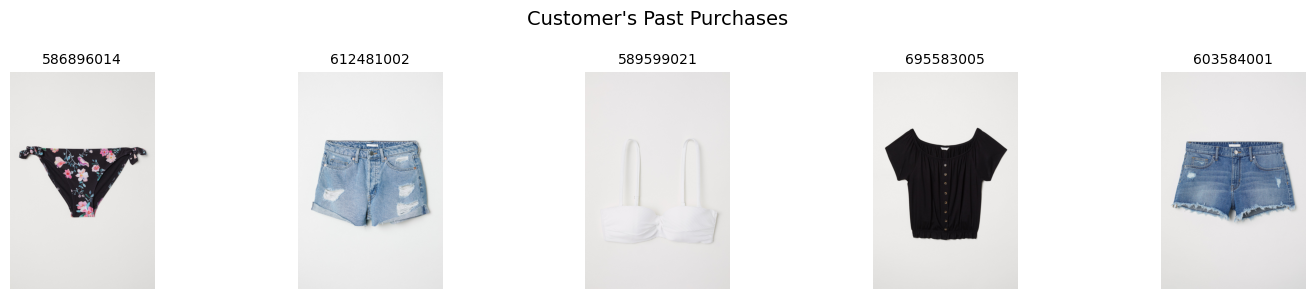

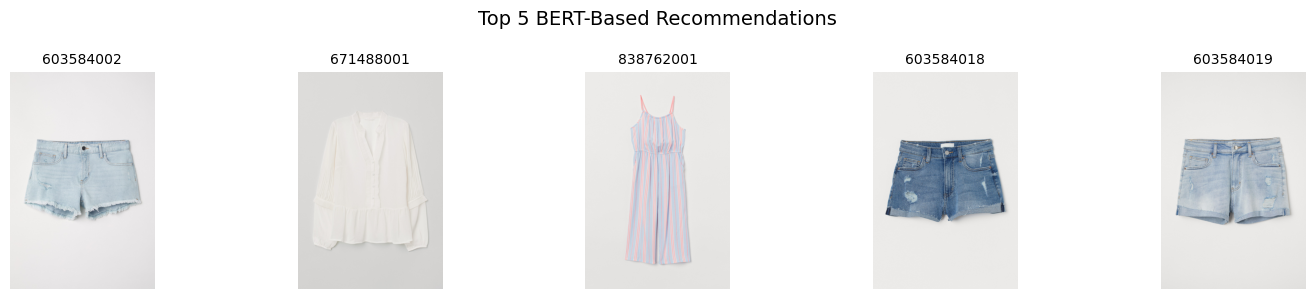

In [32]:
customer_id = customers_df['customer_id'].sample(1).iloc[0]

recommended, purchased = recommend_for_customer(customer_id)

show_article_images(purchased, "Customer's Past Purchases")
show_article_images(recommended, "Top 5 BERT-Based Recommendations")


## Conclusion
Through qualitative examples, we observed that BERT-based embeddings provide richer semantic understanding compared to TF-IDF, resulting in more contextually relevant product recommendations. Visual inspections revealed that BERT better captures subtle style and pattern similarities, which are important in fashion recommendations. This notebook highlights the value of leveraging advanced language models in content-based recommendation systems and sets a foundation for future enhancements, such as incorporating customer behavior or collaborative filtering.